# VOLATILITY SURFACE FOR SPX- BLACK SCHOLES WORLD

#### TECHNICAL SKILLS

   1. Black Scholes model for options price and greeks
   2.  No arbitrage property of Options' price especially no arbitrage bounds for options' price
   3. Dichotomic and Newton Method to solve an equation
   4. Interpolation

### Librairies set up
---

In [81]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.interpolate import interp1d
import time
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from numpy.random import default_rng, SeedSequence


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


sq= SeedSequence()
rng= default_rng(sq)

### Useful fonctions from BS model
---

In [2]:
def d1(S0=100,r=0.01,sigma=0.1,T=1,K=100):
    res= np.log(S0/K) + (r+(sigma**2)/2)*T
    res /= sigma*np.sqrt(T)
    res 
    return res

In [3]:
def d2(S0=100,r=0.01,sigma=0.1,T=1,K=100):
    return d1(S0,r,sigma,T,K) - sigma*np.sqrt(T)

In [4]:
# Prix Call Bs
def prix_call_BS(S0=100,r=0.01,sigma=0.1,T=1,K=100):
    return S0*sps.norm.cdf(d1(S0,r,sigma,T,K),loc=0,scale=1) - K*np.exp(-r*T)*sps.norm.cdf(d2(S0,r,sigma,T,K),loc=0,scale=1)

In [5]:
prix_call_BS()

4.485236409022086

In [6]:
def prix_put_BS(S0=100,r=0.01,sigma=0.1,T=1,K=100):
    return -S0*sps.norm.cdf(-d1(S0,r,sigma,T,K),0,1) + K*np.exp(-r*T)*sps.norm.cdf(-d2(S0,r,sigma,T,K),0,1)
    

In [7]:
prix_put_BS()

3.4902197839388904

### Numerical Methods to find sigma implicite
---


-  **La recherche par dichotomie**


In [8]:
def vol_impl_dicho(market_price, S0=100, r=0.01,T=1, K=100, sigma_inf=1e-4, sigma_sup=10, epsilon=0.01,option_type="call"):
    # Les bornes de l'intervalle dans lequel je cherche ma solution
    sigma_down = sigma_inf
    sigma_up = sigma_sup
    
    #lower_bound_call = max(S0 - K * np.exp(-r * T), 0)
    #lower_bound_put= max(S0 - K * np.exp(-r * T), 0)
    #upper_bound_put= K * np.exp(-r * T)
    
    if option_type=="call":
        #if not (lower_bound_call < market_price < S0):
            #raise ValueError(f"Attention, votre prix du marché ({market_price}) ne respecte pas les contraintes d'arbitrage. Il doit être entre {lower_bound_call} et {S0}.")
        pricer=prix_call_BS
        
    elif option_type=="put":
        #if not (lower_bound_put< market_price < upper_bound_put):
            #raise ValueError(f"Attention, votre prix du marché ({market_price}) ne respecte pas les contraintes d'arbitrage. Il doit être entre {lower_bound_put} et {upper_bound_put}.")
    
        pricer= prix_put_BS
    else:
        NotImplementedError(" Option not implemented")

    
   
# Les cas des bornes
    if abs( pricer(S0=S0,r=r,sigma=sigma_up,T=T,K=K)- market_price) < epsilon:
        return sigma_up
    if abs(pricer(S0=S0,r=r,sigma=sigma_up,T=T,K=K) - market_price) < epsilon:
        return sigma_down
# L'algo de dichotomie
    
    sigma_imp = (sigma_up + sigma_down) / 2
    iteration = 0

    BS_price = pricer(S0=S0,r=r,sigma=sigma_imp,T=T,K=K)

    while abs( BS_price - market_price) > epsilon and iteration < 100:

        if BS_price <= market_price <= pricer(S0=S0,r=r,sigma=sigma_up,T=T,K=K):
                                                                                                
            sigma_down = sigma_imp
        
        if pricer(S0=S0,r=r,sigma=sigma_down,T=T,K=K) <= market_price <= BS_price:
            sigma_up = sigma_imp

        sigma_imp = (sigma_up + sigma_down) / 2
        BS_price = pricer(S0=S0,r=r,sigma=sigma_imp,T=T,K=K)

        iteration += 1
    if iteration >= 100:
        return np.nan
    
    print("valeur trouvée à l'itération:",iteration)
    return sigma_imp
    

In [9]:
# Test
vol_impl_dicho(market_price=prix_call_BS()+ 0.20, S0=100, r=0.01,T=1, K=100, sigma_inf=1e-4, sigma_sup=10, epsilon=0.01,option_type="call")

valeur trouvée à l'itération: 11


0.10507941894531247

-  **La Méthode de Newton**

In [10]:
# Calcul de la dérivée de notre fonction ici c'est le véga
def vega_BS(S0=100,r=0.01,sigma=0.1,T=1,K=100):
    return S0*np.sqrt(T/2*np.pi)*np.exp(-(d1(S0=100,r=0.01,sigma=0.1,T=1,K=100)**2)/2)

In [11]:
vega_BS()

123.92933679732408

In [12]:
# Quelle valeur utilisée comme valeur initiale pour la méthode de Newton?
def vol_impl_init_Newton(S0=100,r=0.01,T=1,K=100):
    return np.sqrt(2*np.abs((np.log(S0/K)+r*T)/T))
sigma0=vol_impl_init_Newton()
sigma0

0.1414213562373095

In [51]:
def vol_impl_Newton(market_price, S0=100, r=0.01, T=1, K=100, epsilon=0.01, option_type="call"):
    
    sigma_imp0= vol_impl_init_Newton(S0,r,T,K)
    
    lower_bound_call = max(S0 - K * np.exp(-r * T), 0)
    lower_bound_put= max(S0 - K * np.exp(-r * T), 0)
    upper_bound_put= K * np.exp(-r * T)
    
    if option_type=="call":
        #if not (lower_bound_call < market_price < S0):
            #raise ValueError(f"Attention, votre prix du marché ({market_price}) ne respecte pas les contraintes d'arbitrage. Il doit être entre {lower_bound_call} et {S0}.")
        pricer=prix_call_BS
        
    elif option_type=="put":
        #if not (lower_bound_put< market_price < upper_bound_put):
            #raise ValueError(f"Attention, votre prix du marché ({market_price}) ne respecte pas les contraintes d'arbitrage. Il doit être entre {lower_bound_put} et {upper_bound_put}.")
    
        pricer= prix_put_BS
    else:
        NotImplementedError(" Option not implimented")

    
    sigma_imp = sigma_imp0  # Initialisation de sigma_imp avec la valeur de départ
    # delta: différence entre la valeur actuelle et la valeur précedente et qui dépend de la précision
    delta = epsilon + 1  # Assurez-vous que delta est suffisamment grand pour entrer dans la boucle
    iteration=0

    while delta > epsilon and iteration < 100:
        vega = vega_BS(S0=S0, r=r, sigma=sigma_imp, T=T, K=K)
        previous_sigma_imp = sigma_imp  # Gardez la trace de l'ancienne valeur de sigma_imp
        sigma_imp = -(pricer(S0=S0, r=r, sigma=sigma_imp, T=T, K=K) - market_price) / vega + sigma_imp
        delta = abs(sigma_imp - previous_sigma_imp)
        iteration += 1
    
    print("valeur trouvée à l'itération:",iteration)
    return sigma_imp


# Ne jamais appeller des fonctions à l'intérieur d'une fonction avec des valeurs par défaut
# Cela fausse des résultats

    

In [52]:
vol_impl_Newton(market_price=prix_call_BS()+0.20)

valeur trouvée à l'itération: 2


0.1219476202643566

In [53]:
sigma_imp0=vol_impl_init_Newton(S0=5430.3,r=0.05,T=4/12,K=5825)
sigma_imp0


0.5665577732938684

In [54]:
a=vol_impl_dicho(market_price=475,S0=5430.3, r=0.05, T=4/12,K=5125)
a

valeur trouvée à l'itération: 17


0.19018446388244625

In [55]:
vol_impl_Newton(market_price=475, S0=5430.3, r=0.05, T=4/12,K=5125)

valeur trouvée à l'itération: 9


0.2180796954216793

### VOLATILITY SURFACE
---

In [56]:
data_set=pd.read_csv('data/spx_quotedata.csv',header=2,parse_dates=['Expiration Date'])

In [57]:
data_set.head()

,Expiration Date,Calls,Last Sale,Net,Bid,Ask,Volume,Open Interest,Strike,Puts,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,Open Interest.1
0,2024-02-12,SPXW240212C01200000,3516.61,0.0,3818.5,3827.5,0,2,1200,SPXW240212P01200000,0.05,0.025,0.0,0.05,10,2
1,2024-02-12,SPXW240212C01400000,0.00,0.0,3618.5,3627.5,0,0,1400,SPXW240212P01400000,0.00,0.000,0.0,0.05,0,0
2,2024-02-12,SPXW240212C01600000,0.00,0.0,3418.5,3427.5,0,0,1600,SPXW240212P01600000,0.05,0.025,0.0,0.05,1,0
3,2024-02-12,SPXW240212C01800000,0.00,0.0,3218.5,3227.5,0,0,1800,SPXW240212P01800000,0.07,0.000,0.0,0.05,0,3
4,2024-02-12,SPXW240212C02000000,2994.60,0.0,3018.5,3027.5,0,8,2000,SPXW240212P02000000,0.05,0.000,0.0,0.05,0,4


In [58]:
S0=4968	 # The spot change from 5 026,83 to 4 967,94 
date_to_use=pd.to_datetime("Tue Feb 13 2024")

### Dataset Cleaning

In [59]:
# Dataset Cleaning
rename_dict = {
    'Calls': 'Calls',
    'Last Sale': 'Last Sale_call',
    'Net': 'Net_call',
    'Bid': 'Bid_call',
    'Ask': 'Ask_call',
    'Volume': 'Volume_call',
    'Open Interest': 'Open Interest_call',
    'Strike': 'Strike',
    'Puts': 'Puts',
    'Last Sale.1': 'Last Sale_put',
    'Net.1': 'Net_put',
    'Bid.1': 'Bid_put',
    'Ask.1': 'Ask_put',
    'Volume.1': 'Volume_put',
    'Open Interest.1': 'Open Interest_put'
}

data_set.rename(columns=rename_dict, inplace=True)
data_set.head(10)

,Expiration Date,Calls,Last Sale_call,Net_call,Bid_call,Ask_call,Volume_call,Open Interest_call,Strike,Puts,Last Sale_put,Net_put,Bid_put,Ask_put,Volume_put,Open Interest_put
0,2024-02-12,SPXW240212C01200000,3516.61,0.0,3818.5,3827.5,0,2,1200,SPXW240212P01200000,0.05,0.025,0.0,0.05,10,2
1,2024-02-12,SPXW240212C01400000,0.00,0.0,3618.5,3627.5,0,0,1400,SPXW240212P01400000,0.00,0.000,0.0,0.05,0,0
2,2024-02-12,SPXW240212C01600000,0.00,0.0,3418.5,3427.5,0,0,1600,SPXW240212P01600000,0.05,0.025,0.0,0.05,1,0
3,2024-02-12,SPXW240212C01800000,0.00,0.0,3218.5,3227.5,0,0,1800,SPXW240212P01800000,0.07,0.000,0.0,0.05,0,3
4,2024-02-12,SPXW240212C02000000,2994.60,0.0,3018.5,3027.5,0,8,2000,SPXW240212P02000000,0.05,0.000,0.0,0.05,0,4
5,2024-02-12,SPXW240212C02200000,0.00,0.0,2818.5,2827.5,0,0,2200,SPXW240212P02200000,0.05,0.000,0.0,0.05,0,3
6,2024-02-12,SPXW240212C02400000,0.00,0.0,2618.5,2627.5,0,3,2400,SPXW240212P02400000,0.05,0.000,0.0,0.05,0,30
7,2024-02-12,SPXW240212C02600000,2425.60,0.0,2418.5,2427.5,0,3,2600,SPXW240212P02600000,0.05,0.000,0.0,0.05,0,5
8,2024-02-12,SPXW240212C02800000,0.00,0.0,2218.5,2227.5,0,0,2800,SPXW240212P02800000,0.05,0.000,0.0,0.05,0,115
9,2024-02-12,SPXW240212C03000000,0.00,0.0,2018.5,2027.5,0,0,3000,SPXW240212P03000000,0.05,0.000,0.0,0.05,0,91


 Le premier travail de nettoyage à faire devrait consiter à vérifier que le prix du marché de notre option fournie par la dataset vérifie bien les bornes d'arbitrage fournies par la théorie ie:

 Pour le call: max(S0 - K * np.exp(-r * T), 0) < market_price < S0

 Pour le put:  max(S0 - K * np.exp(-r * T), 0) < market_price < K * np.exp(-r * T)

 Bon ici on a que le bid et le Ask et on va implémenter ensuite le prix Mid. Doit on checker si le prix Mid tombe entre ces bornes ?

In [60]:
data_set['Mid_call']=(data_set['Bid_call']+data_set['Ask_call'])/2
data_set['Mid_put']=(data_set['Bid_put']+data_set['Ask_put'])/2
data_set=data_set[data_set["Expiration Date"]>date_to_use]
data_set['Day_to_expiration'] = data_set["Expiration Date"].apply(
    lambda x: len(pd.bdate_range(start=date_to_use, end=x))-1
)
data_set['Spread_call']=data_set['Ask_call']-data_set['Bid_call']
data_set['Spread_put']=data_set['Ask_put']-data_set['Bid_put']
data_set['Moneyness']=data_set['Strike']/S0


data_set.tail()

,Expiration Date,Calls,Last Sale_call,Net_call,Bid_call,Ask_call,Volume_call,Open Interest_call,Strike,Puts,...,Bid_put,Ask_put,Volume_put,Open Interest_put,Mid_call,Mid_put,Day_to_expiration,Spread_call,Spread_put,Moneyness
11055,2029-12-21,SPX291221C07200000,0.00,0.0,376.1,477.2,0,0,7200,SPX291221P07200000,...,1281.5,1485.3,0,0,426.65,1383.40,1528,101.1,203.8,1.449275
11056,2029-12-21,SPX291221C07400000,0.00,0.0,326.6,424.8,0,0,7400,SPX291221P07400000,...,1386.9,1593.8,0,0,375.70,1490.35,1528,98.2,206.9,1.489533
11057,2029-12-21,SPX291221C07600000,280.00,0.0,282.3,377.5,0,1,7600,SPX291221P07600000,...,1497.5,1707.2,0,0,329.90,1602.35,1528,95.2,209.7,1.529791
11058,2029-12-21,SPX291221C07800000,207.86,0.0,242.9,335.1,0,0,7800,SPX291221P07800000,...,1613.2,1825.5,0,0,289.00,1719.35,1528,92.2,212.3,1.570048
11059,2029-12-21,SPX291221C08000000,243.45,0.0,208.2,297.3,0,9,8000,SPX291221P08000000,...,1733.7,1948.2,0,0,252.75,1840.95,1528,89.1,214.5,1.610306


In [61]:
yield_curve = {
    'duration': ['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'],
    'rate': [5.48, 5.52, 5.45, 5.46, 5.32, 4.99, 4.64, 4.44, 4.31, 4.33, 4.31, 4.59, 4.46]
}

yield_curve = {
    'duration': [21, 42, 63, 84, 126, 252, 504, 756, 1260, 1764, 2520, 5040, 7560],
    'rate': [5.48, 5.52, 5.45, 5.46, 5.32, 4.99, 4.64, 4.44, 4.31, 4.33, 4.31, 4.59, 4.46]
}

yield_curve_df = pd.DataFrame(yield_curve)



def get_nearest_rate(days):
    for idx, dur in enumerate(yield_curve_df['duration']):
        if days <= dur:
            return yield_curve_df.iloc[idx]['rate']

data_set['Rate'] = data_set['Day_to_expiration'].apply(get_nearest_rate)
data_set['Rate']/=100
data_set.tail()

,Expiration Date,Calls,Last Sale_call,Net_call,Bid_call,Ask_call,Volume_call,Open Interest_call,Strike,Puts,...,Ask_put,Volume_put,Open Interest_put,Mid_call,Mid_put,Day_to_expiration,Spread_call,Spread_put,Moneyness,Rate
11055,2029-12-21,SPX291221C07200000,0.00,0.0,376.1,477.2,0,0,7200,SPX291221P07200000,...,1485.3,0,0,426.65,1383.40,1528,101.1,203.8,1.449275,0.0433
11056,2029-12-21,SPX291221C07400000,0.00,0.0,326.6,424.8,0,0,7400,SPX291221P07400000,...,1593.8,0,0,375.70,1490.35,1528,98.2,206.9,1.489533,0.0433
11057,2029-12-21,SPX291221C07600000,280.00,0.0,282.3,377.5,0,1,7600,SPX291221P07600000,...,1707.2,0,0,329.90,1602.35,1528,95.2,209.7,1.529791,0.0433
11058,2029-12-21,SPX291221C07800000,207.86,0.0,242.9,335.1,0,0,7800,SPX291221P07800000,...,1825.5,0,0,289.00,1719.35,1528,92.2,212.3,1.570048,0.0433
11059,2029-12-21,SPX291221C08000000,243.45,0.0,208.2,297.3,0,9,8000,SPX291221P08000000,...,1948.2,0,0,252.75,1840.95,1528,89.1,214.5,1.610306,0.0433


In [62]:
def calculate_nan_percentage(dataframe):
    nan_counts = dataframe.isna().sum()

    nan_percentage = (nan_counts / len(dataframe)) * 100

    return nan_percentage.sort_values(ascending=False)

In [63]:
calculate_nan_percentage(data_set)

Expiration Date       0.0
Bid_put               0.0
Moneyness             0.0
Spread_put            0.0
Spread_call           0.0
Day_to_expiration     0.0
Mid_put               0.0
Mid_call              0.0
Open Interest_put     0.0
Volume_put            0.0
Ask_put               0.0
Net_put               0.0
Calls                 0.0
Last Sale_put         0.0
Puts                  0.0
Strike                0.0
Open Interest_call    0.0
Volume_call           0.0
Ask_call              0.0
Bid_call              0.0
Net_call              0.0
Last Sale_call        0.0
Rate                  0.0
dtype: float64

### Call Volatility Surface

In [64]:
call_columns=["Expiration Date","Day_to_expiration","Calls","Spread_call","Mid_call","Volume_call","Strike","Moneyness","Rate"]
call_dataset=data_set[call_columns]

Since we are using the mid price, which is not market data but rather a calculation made by us to determine the implied volatility, we are introducing a bias. The question is, what factors can influence this bias?

The article https://www.ludgerhentschel.com/PDFs/IV.pdf demonstrates that as the spread increases, the bias also increases. Moreover, by observing my data, the natural variable I can relate to the spread is the volume because I notice that less liquid options have large spreads.

Conclusion: I plot a diagram of the volume as a function of the option's expiration date, with points sized according to the value of the spread.

c:\Users\SHUNGU\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


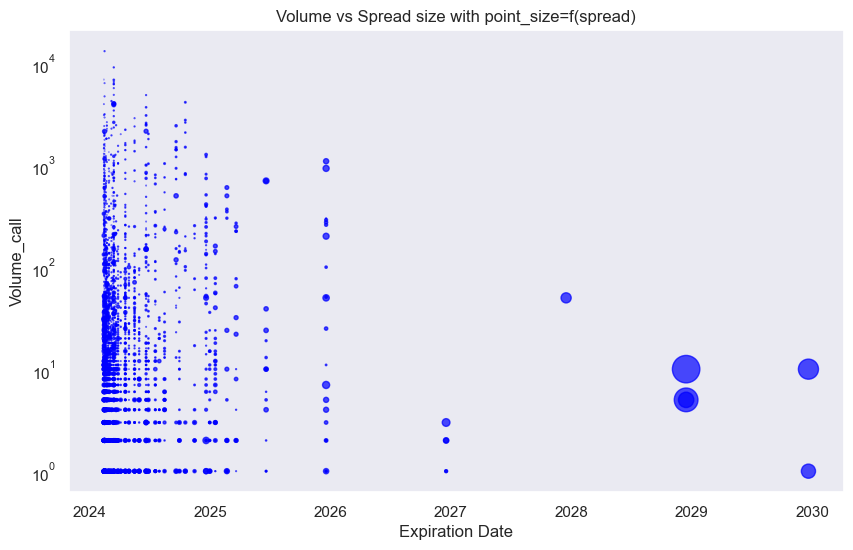

In [65]:
fig, ax1 = plt.subplots(figsize=(10, 6))

scatter = ax1.scatter(call_dataset["Expiration Date"], call_dataset["Volume_call"], 
                      s=call_dataset["Spread_call"], alpha=0.7, label="Volume call", color="blue")
plt.grid()
ax1.set_xlabel("Expiration Date")
ax1.set_ylabel("Volume_call")
ax1.set_title("Volume vs Spread size with point_size=f(spread)")

ax1.set_yscale('log')

plt.show()

The plot shows that higher volume leads to lower spread, indicating at the same time greater liquidity. However, this relationship doesn't hold true for options with expiration dates beyond mid-2025. To address this issue, I will focus on options with expiration dates before mid-2025 and a volume greater than zero in my dataset.

In [66]:
call_dataset=data_set[call_columns]

In [67]:
filtered_dataset_call=call_dataset[(call_dataset['Volume_call']>0)&(call_dataset['Expiration Date']>="2024-02-20")&(call_dataset['Expiration Date']<="2025-05-01")]


In [68]:
filtered_dataset_call

,Expiration Date,Day_to_expiration,Calls,Spread_call,Mid_call,Volume_call,Strike,Moneyness,Rate
1522,2024-02-20,5,SPXW240220C04300000,6.1,707.05,6,4300,0.865539,0.0548
1528,2024-02-20,5,SPXW240220C04450000,6.7,557.05,32,4450,0.895733,0.0548
1530,2024-02-20,5,SPXW240220C04500000,6.0,507.50,2,4500,0.905797,0.0548
1532,2024-02-20,5,SPXW240220C04550000,6.6,457.30,37,4550,0.915862,0.0548
1533,2024-02-20,5,SPXW240220C04560000,6.1,447.65,3,4560,0.917874,0.0548
...,...,...,...,...,...,...,...,...,...
10686,2025-03-21,288,SPX250321C05500000,2.2,168.30,2,5500,1.107085,0.0464
10692,2025-03-21,288,SPX250321C06200000,0.6,22.50,2,6200,1.247987,0.0464
10693,2025-03-21,288,SPX250321C06400000,0.5,12.05,4,6400,1.288245,0.0464
10695,2025-03-21,288,SPX250321C06800000,0.4,3.90,10,6800,1.368760,0.0464


In [69]:
filtered_dataset_call['IV']=filtered_dataset_call.apply(
    lambda x: vol_impl_Newton(
        market_price=x['Mid_call'],
        S0=S0,
        r=x['Rate'],
        T=x['Day_to_expiration']/252,
        K=x['Strike'],
        #sigma_inf=1e-3,
        #sigma_sup=2,
        option_type='call'
    ),
    axis=1
)

"""filtered_dataset_call['Delta']=filtered_dataset_call.apply(
    lambda x: np.round((
        S0=S0,
        T=x['Day_to_expiration']/252,
        sigma=x['IV'],
        r=x['Rate'],
        K=x['Strike'],
    ),2),
    axis=1
)"""

valeur trouvée à l'itération: 19
valeur trouvée à l'itération: 18
valeur trouvée à l'itération: 17
valeur trouvée à l'itération: 16
valeur trouvée à l'itération: 16
valeur trouvée à l'itération: 14
valeur trouvée à l'itération: 14
valeur trouvée à l'itération: 14
valeur trouvée à l'itération: 13
valeur trouvée à l'itération: 13
valeur trouvée à l'itération: 13
valeur trouvée à l'itération: 13
valeur trouvée à l'itération: 12
valeur trouvée à l'itération: 12
valeur trouvée à l'itération: 12
valeur trouvée à l'itération: 12
valeur trouvée à l'itération: 12
valeur trouvée à l'itération: 11
valeur trouvée à l'itération: 11
valeur trouvée à l'itération: 11
valeur trouvée à l'itération: 11
valeur trouvée à l'itération: 11
valeur trouvée à l'itération: 11
valeur trouvée à l'itération: 11
valeur trouvée à l'itération: 10
valeur trouvée à l'itération: 10
valeur trouvée à l'itération: 10
valeur trouvée à l'itération: 10
valeur trouvée à l'itération: 10
valeur trouvée à l'itération: 9
valeur trou

C:\Users\SHUNGU\AppData\Local\Temp\ipykernel_23280\1484759704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset_call['IV']=filtered_dataset_call.apply(


"filtered_dataset_call['Delta']=filtered_dataset_call.apply(\n    lambda x: np.round((\n        S0=S0,\n        T=x['Day_to_expiration']/252,\n        sigma=x['IV'],\n        r=x['Rate'],\n        K=x['Strike'],\n    ),2),\n    axis=1\n)"

In [70]:
calculate_nan_percentage(filtered_dataset_call)

Expiration Date      0.0
Day_to_expiration    0.0
Calls                0.0
Spread_call          0.0
Mid_call             0.0
Volume_call          0.0
Strike               0.0
Moneyness            0.0
Rate                 0.0
IV                   0.0
dtype: float64

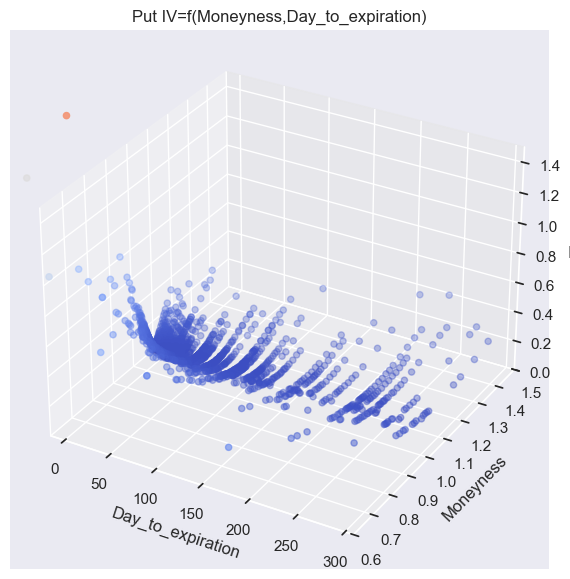

In [71]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(filtered_dataset_call['Day_to_expiration'],filtered_dataset_call['Moneyness'],  filtered_dataset_call['IV'], marker='o',
          c=filtered_dataset_call['IV'],  
                     cmap='coolwarm',
         )

ax.set_ylabel('Moneyness')
ax.set_xlabel('Day_to_expiration')
ax.set_zlabel('IV')
ax.set_ylim(0.6, 1.5)
ax.set_zlim(0., 1.5)

ax.set_title('Put IV=f(Moneyness,Day_to_expiration)')

plt.show()

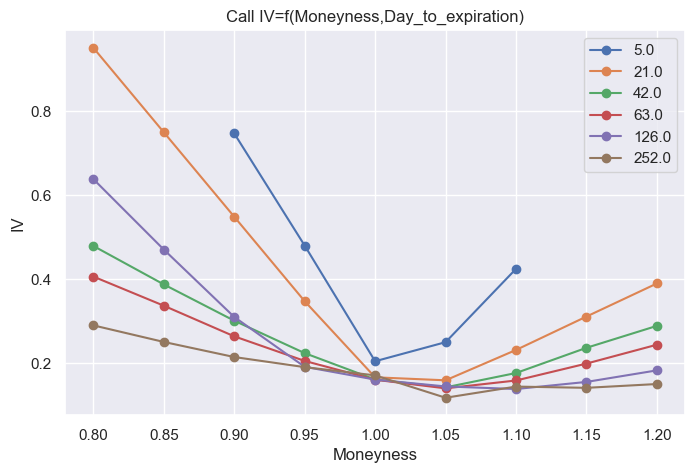

In [72]:
from scipy.interpolate import griddata


Tenor = np.array([5, 21, 42, 63, 126, 252])
Moneyness = np.array([0.8 + i * 0.05 for i in range(9)])

two_day_array = np.array(np.meshgrid(Tenor, Moneyness)).T.reshape(-1, 2)

IV_interp = griddata((filtered_dataset_call['Day_to_expiration'],filtered_dataset_call['Moneyness']), filtered_dataset_call['IV'], (two_day_array[:,0], two_day_array[:,1]), method='linear')


df_interp = pd.DataFrame({
    'Day_to_expiration': two_day_array[:,0],
    'Moneyness': two_day_array[:,1],
    'IV_interp': IV_interp.flatten()
}).dropna()

unique_days = df_interp['Day_to_expiration'].unique()

plt.figure(figsize=(8, 5))
for day in unique_days:
    
    
    subset = df_interp[df_interp['Day_to_expiration'] == day]
    
    plt.plot(subset['Moneyness'], subset['IV_interp'], marker='o',label=day)
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.title(f'Call IV=f(Moneyness,Day_to_expiration)')
    plt.grid(True)
    plt.legend()
    
plt.show()

1. As we could see, the implied volatility decrease with time to maturity for a fixed moneyness, this is because shorter-term options are less sensitive to large price swings, and the uncertainty decreases as the expiration date approaches.
\

2. Implied volatility decreases with moneyness for ITM SPX call options, in fact ITM options have a higher intrinsic value and less time value, thus they are less sensitive to changes in the underlying asset's volatility, but it increases with moneyness for OTM SPX call options which make sense because they are more sensitive to changes in the underlying asset's volatility since their value is highly dependent on the potential for the underlying asset to reach the strike price before expiration

### Put Volatility Surface

In [73]:
put_columns=["Expiration Date","Day_to_expiration","Puts","Spread_put","Mid_put","Volume_put","Strike","Moneyness",'Rate']

put_dataset=data_set[put_columns]



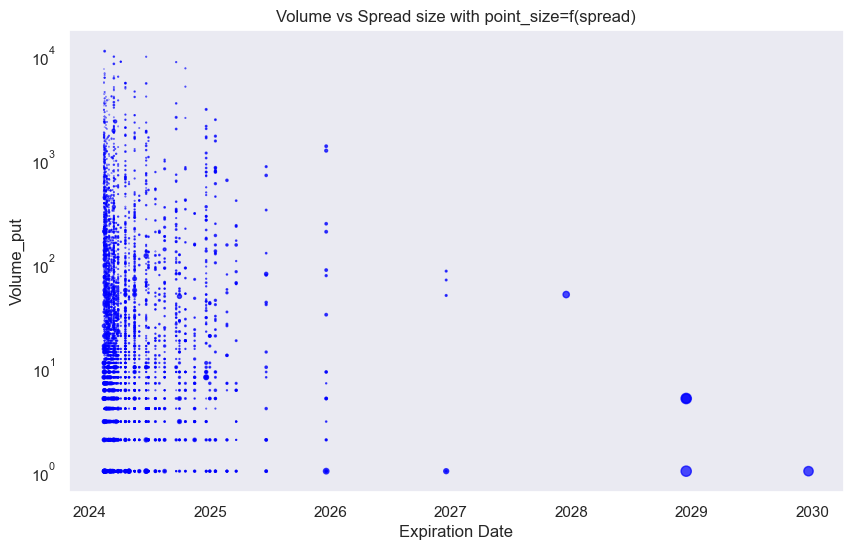

In [74]:
fig, ax1 = plt.subplots(figsize=(10, 6))

scatter = ax1.scatter(put_dataset["Expiration Date"], put_dataset["Volume_put"], 
                      s=put_dataset["Spread_put"], alpha=0.7, label="Volume put", color="blue")
plt.grid()
ax1.set_xlabel("Expiration Date")
ax1.set_ylabel("Volume_put")
ax1.set_title("Volume vs Spread size with point_size=f(spread)")

ax1.set_yscale('log')

plt.show()

Same conclusions as for the call options but in this case, the spread is very low until 2027.

In [75]:
put_dataset=put_dataset[put_dataset['Volume_put']>0]


put_filtered_dataset=put_dataset[(put_dataset['Expiration Date']>="2024-02-20")&(put_dataset['Expiration Date']<="2025-06-01")]

put_filtered_dataset

,Expiration Date,Day_to_expiration,Puts,Spread_put,Mid_put,Volume_put,Strike,Moneyness,Rate
1508,2024-02-20,5,SPXW240220P03400000,0.05,0.025,25,3400,0.684380,0.0548
1509,2024-02-20,5,SPXW240220P03600000,0.10,0.050,1256,3600,0.724638,0.0548
1510,2024-02-20,5,SPXW240220P03700000,0.10,0.050,1000,3700,0.744767,0.0548
1511,2024-02-20,5,SPXW240220P03800000,0.05,0.075,1251,3800,0.764895,0.0548
1512,2024-02-20,5,SPXW240220P03850000,0.05,0.075,406,3850,0.774960,0.0548
...,...,...,...,...,...,...,...,...,...
10672,2025-03-21,288,SPX250321P04800000,1.80,178.600,6,4800,0.966184,0.0464
10677,2025-03-21,288,SPX250321P05050000,2.10,244.350,6,5050,1.016506,0.0464
10678,2025-03-21,288,SPX250321P05100000,2.00,260.300,83,5100,1.026570,0.0464
10679,2025-03-21,288,SPX250321P05150000,2.20,277.200,65,5150,1.036634,0.0464


In [76]:
put_filtered_dataset['IV']=put_filtered_dataset.apply(
    lambda x: vol_impl_Newton(
        market_price=x['Mid_put'],
        S0=S0,
        r=x['Rate'],
        T=x['Day_to_expiration']/252,
        K=x['Strike'],
        #sigma_inf=1e-3,
        #sigma_sup=2,
        option_type='put'
    ),
    axis=1
)

"""filtered_dataset_call['Delta']=filtered_dataset_call.apply(
    lambda x: np.round((
        S0=S0,
        T=x['Day_to_expiration']/252,
        sigma=x['IV'],
        r=x['Rate'],
        K=x['Strike'],
    ),2),
    axis=1
)"""

valeur trouvée à l'itération: 42
valeur trouvée à l'itération: 38
valeur trouvée à l'itération: 36
valeur trouvée à l'itération: 34
valeur trouvée à l'itération: 33
valeur trouvée à l'itération: 32
valeur trouvée à l'itération: 32
valeur trouvée à l'itération: 31
valeur trouvée à l'itération: 30
valeur trouvée à l'itération: 29
valeur trouvée à l'itération: 28
valeur trouvée à l'itération: 27
valeur trouvée à l'itération: 26
valeur trouvée à l'itération: 25
valeur trouvée à l'itération: 24
valeur trouvée à l'itération: 24
valeur trouvée à l'itération: 23
valeur trouvée à l'itération: 23
valeur trouvée à l'itération: 22
valeur trouvée à l'itération: 22
valeur trouvée à l'itération: 21
valeur trouvée à l'itération: 21
valeur trouvée à l'itération: 20
valeur trouvée à l'itération: 20
valeur trouvée à l'itération: 20
valeur trouvée à l'itération: 20
valeur trouvée à l'itération: 20
valeur trouvée à l'itération: 20
valeur trouvée à l'itération: 19
valeur trouvée à l'itération: 19
valeur tro

C:\Users\SHUNGU\AppData\Local\Temp\ipykernel_23280\1663497003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_filtered_dataset['IV']=put_filtered_dataset.apply(


"filtered_dataset_call['Delta']=filtered_dataset_call.apply(\n    lambda x: np.round((\n        S0=S0,\n        T=x['Day_to_expiration']/252,\n        sigma=x['IV'],\n        r=x['Rate'],\n        K=x['Strike'],\n    ),2),\n    axis=1\n)"

In [77]:
calculate_nan_percentage(put_filtered_dataset)

Expiration Date      0.0
Day_to_expiration    0.0
Puts                 0.0
Spread_put           0.0
Mid_put              0.0
Volume_put           0.0
Strike               0.0
Moneyness            0.0
Rate                 0.0
IV                   0.0
dtype: float64

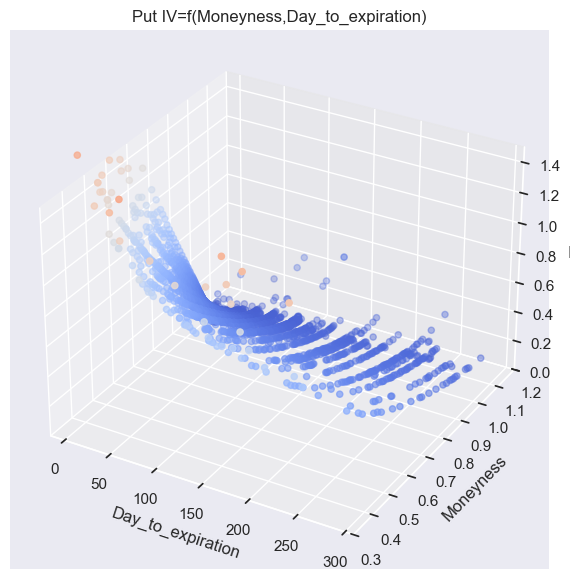

In [78]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(put_filtered_dataset['Day_to_expiration'],put_filtered_dataset['Moneyness'],  put_filtered_dataset['IV'], marker='o',c=put_filtered_dataset['IV'],  
                     cmap='coolwarm',
           )

ax.set_ylabel('Moneyness')
ax.set_xlabel('Day_to_expiration')
ax.set_zlabel('IV')
ax.set_ylim(0.3, 1.2)
ax.set_zlim(0., 1.5)

ax.set_title('Put IV=f(Moneyness,Day_to_expiration)')

plt.show()

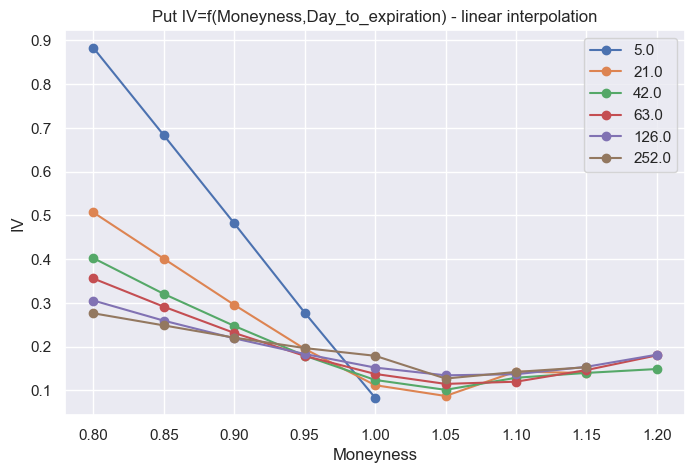

In [79]:
Tenor = np.array([5, 21, 42, 63, 126, 252])
Moneyness = np.array([0.8 + i * 0.05 for i in range(9)])

two_day_array = np.array(np.meshgrid(Tenor, Moneyness)).T.reshape(-1, 2)

IV_interp = griddata((put_filtered_dataset['Day_to_expiration'],put_filtered_dataset['Moneyness']), put_filtered_dataset['IV'], (two_day_array[:,0], two_day_array[:,1]), method='linear')


df_interp = pd.DataFrame({
    'Day_to_expiration': two_day_array[:,0],
    'Moneyness': two_day_array[:,1],
    'IV_interp': IV_interp.flatten()
}).dropna()

unique_days = df_interp['Day_to_expiration'].unique()

plt.figure(figsize=(8, 5))
for day in unique_days:
    
    subset = df_interp[df_interp['Day_to_expiration'] == day]
    
    plt.plot(subset['Moneyness'], subset['IV_interp'], marker='o',label=day)
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.title(f'Put IV=f(Moneyness,Day_to_expiration) - linear interpolation')
    plt.grid(True)
    plt.legend()
    
plt.show()

It seems that there are not enough value for ITM put options to give some accurate linear interpolation, I will use the nearest method.

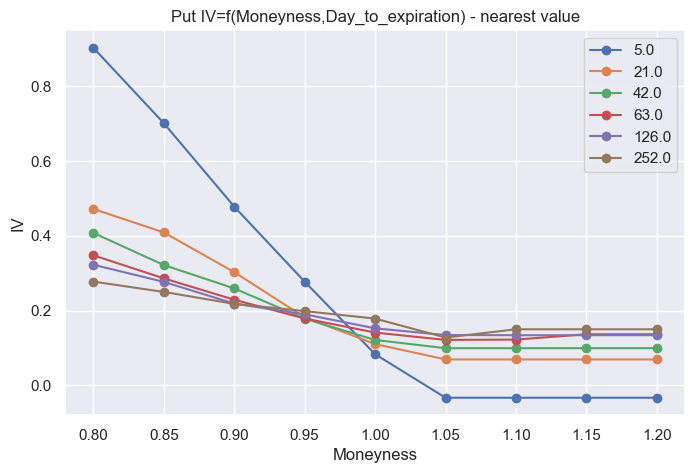

In [80]:
IV_interp = griddata((put_filtered_dataset['Day_to_expiration'],put_filtered_dataset['Moneyness']), put_filtered_dataset['IV'], (two_day_array[:,0], two_day_array[:,1]), method='nearest')


df_interp = pd.DataFrame({
    'Day_to_expiration': two_day_array[:,0],
    'Moneyness': two_day_array[:,1],
    'IV_interp': IV_interp.flatten()
}).dropna()

unique_days = df_interp['Day_to_expiration'].unique()

plt.figure(figsize=(8, 5))
for day in unique_days:
    
    subset = df_interp[df_interp['Day_to_expiration'] == day]
    
    plt.plot(subset['Moneyness'], subset['IV_interp'], marker='o',label=day)
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.title(f'Put IV=f(Moneyness,Day_to_expiration) - nearest value')
    plt.grid(True)
    plt.legend()
    
plt.show()

As we could see, the implied volatility decrease with time to maturity for a fixed moneyness, but there is a particular inversion of the monotony when we are ATM.